# Google trend data select by deferred

## INFO
- \[Encoding\] : `utf-8`
- \[Author\] : `yen-nan ho`
- \[Contact\] : `aaron1aaron2@gmail.com`
- \[GitHub\] : `https://github.com/aaron1aaron2`
- \[Create Date\] :  `20210910`



In [75]:
import os
import pandas as pd
import numpy as np

from scipy import stats

output_folder = 'data/proccess/2_google_trend'
if not os.path.exists(output_folder):
    os.makedirs(output_folder)

In [79]:
def combine_google_trend_data(data_path, file_extract_pat):
    """合併個關鍵字手動下載的結果"""
    file_ls = [i for i in os.listdir(data_path) if i.find('.csv')!=-1]

    result = pd.DataFrame()
    for file in file_ls:
        popularity = pd.read_csv(os.path.join(data_path, file), skiprows=3, header=None)
        popularity.columns = ['date', 'search_rate']
        popularity['file'] = file

        result = result.append(popularity)

    result = pd.concat([result, result['date'].str.extract('(?P<year>\d+)-(?P<month>\d+)')], axis=1)
    result = pd.concat([result, result['file'].str.extract(file_extract_pat)], axis=1)

    return result

def combine_google_trend_touristflow(touristflow_df:pd.DataFrame, googletrend_df:pd.DataFrame):
    pd.options.mode.chained_assignment = None

    touristflow_set = set(touristflow_df['name'].to_list())
    googletrend_set = set(googletrend_df['name'].to_list())
    print('spots not find in googletrend data: ', touristflow_set - googletrend_set) 

    touristflow_df = touristflow_df[touristflow_df['name'].isin(googletrend_df['name'])]

    result = touristflow_df.merge(googletrend_df, how='left', on=['name', 'month', 'year'])
    df = result[['name', 'year', 'month', 'touristflow', 'search_rate']]
    
    df['touristflow_nor'] = 0
    df['search_rate_nor'] = 0

    df.reset_index(drop=True, inplace=True)
    def zscore_normalization(data:pd.Series):
        mean = data.mean()
        sd = data.std()
        return (data - mean)/sd

    for spot in df['name'].unique():
        tmp = df.loc[df['name']==spot, 'touristflow']
        df.loc[tmp.index, 'touristflow_nor'] = zscore_normalization(tmp)

        tmp = df.loc[df['name']==spot, 'search_rate']
        df.loc[tmp.index, 'search_rate_nor'] = zscore_normalization(tmp)

    # df.dropna(inplace=True) #台東海洋夢想館 peopleflow 為 0

    return df

def get_deferred(df, shift_num_ls):

    def shift_month(group, target_cols, shift_num):
        for col in target_cols:
            group[col] = group[col].shift(shift_num)
        
        group.dropna(inplace=True)

        return group

    def corr_test(df:pd.DataFrame, col1, col2, tag):
        coor, p = stats.spearmanr(df[col1].values, df[col2].values)
        pearson = df.loc[:, [col1, col2]].corr().iloc[0, 1]
        spearman = df.loc[:, [col1, col2]].corr('spearman').iloc[0, 1]
        kendall = df.loc[:, [col1, col2]].corr('kendall').iloc[0, 1]

        return {f'spearmanr_stats_{tag}':coor, f'p_{tag}':p, f'pearson_{tag}':pearson, f'spearman_{tag}':spearman, f'kendall_{tag}':kendall}
    
    result_dt = {'all': corr_test(df, 'touristflow_nor', 'search_rate_nor', 0)}

    for spot in df['name'].unique():
        result_dt.update({spot: corr_test(df.loc[df['name']==spot], 'touristflow_nor', 'search_rate_nor', 0)})
        for num in shift_num_ls:
            df_sh = df.groupby('name').apply(shift_month, target_cols=['touristflow_nor', 'touristflow'], shift_num=num)

            result_dt['all'].update(corr_test(df_sh, 'touristflow_nor', 'search_rate_nor', num))
            result_dt[spot].update(corr_test(df_sh.loc[df_sh['name']==spot], 'touristflow_nor', 'search_rate_nor', num))

    return result_dt


## 1. 清整合併資料(v1)

In [3]:
# 將 google trand 的原始資料集合起來
googletrend_df = combine_google_trend_data("data/raw/google_trend/v1", 
                                            file_extract_pat='(?P<name>.+)-(?P<keyword>.+)-(?P<flowtype>.+).csv') 

In [4]:
googletrend_df

,date,search_rate,file,year,month,name,keyword,flowtype
0,2011-01,0,秀姑巒溪遊客中心-秀姑巒溪-search.csv,2011,01,秀姑巒溪遊客中心,秀姑巒溪,search
1,2011-02,0,秀姑巒溪遊客中心-秀姑巒溪-search.csv,2011,02,秀姑巒溪遊客中心,秀姑巒溪,search
2,2011-03,0,秀姑巒溪遊客中心-秀姑巒溪-search.csv,2011,03,秀姑巒溪遊客中心,秀姑巒溪,search
3,2011-04,33,秀姑巒溪遊客中心-秀姑巒溪-search.csv,2011,04,秀姑巒溪遊客中心,秀姑巒溪,search
4,2011-05,59,秀姑巒溪遊客中心-秀姑巒溪-search.csv,2011,05,秀姑巒溪遊客中心,秀姑巒溪,search
...,...,...,...,...,...,...,...,...
120,2021-01,24,台東森林公園-台東 森林 公園-search.csv,2021,01,台東森林公園,台東 森林 公園,search
121,2021-02,40,台東森林公園-台東 森林 公園-search.csv,2021,02,台東森林公園,台東 森林 公園,search
122,2021-03,25,台東森林公園-台東 森林 公園-search.csv,2021,03,台東森林公園,台東 森林 公園,search
123,2021-04,23,台東森林公園-台東 森林 公園-search.csv,2021,04,台東森林公園,台東 森林 公園,search


In [5]:
googletrend_df.to_csv(os.path.join(output_folder, "googletrend_data_combine.v1.csv"), index=False)
googletrend_df.pivot(index='date', columns='name', values='search_rate')\
    .to_csv("data/final/2_googletrend.csv") 

## 2. 將 google trend 得到的流量與 Touristflow 進行合併

In [19]:
SUM_MONTH = False

# 對(點-年-月) group ，計算每個景點每個年-月的加總
googletrend_df['month'] = googletrend_df['month'].astype(int)
googletrend_df = googletrend_df[['name', 'year', 'month', 'search_rate']]

if SUM_MONTH:
    googletrend_df = googletrend_df.groupby(['name', 'year', 'month']).sum()['search_rate']
    googletrend_df = googletrend_df.reset_index()

In [20]:
googletrend_df

,name,year,month,search_rate
0,秀姑巒溪遊客中心,2011,1,0
1,秀姑巒溪遊客中心,2011,2,0
2,秀姑巒溪遊客中心,2011,3,0
3,秀姑巒溪遊客中心,2011,4,33
4,秀姑巒溪遊客中心,2011,5,59
...,...,...,...,...
120,台東森林公園,2021,1,24
121,台東森林公園,2021,2,40
122,台東森林公園,2021,3,25
123,台東森林公園,2021,4,23


In [55]:
# 
touristflow_df = pd.read_csv('data/final/0_touristflow.csv') 

cols = touristflow_df.columns.to_list()
touristflow_df = touristflow_df.melt(id_vars=cols[:2], value_vars=cols[2:], var_name='name', value_name='touristflow')
touristflow_df.rename(columns={'年度': 'year', '月份': 'month'}, inplace=True)
touristflow_df['year'] = touristflow_df['year'].str.extract('\((\d+)\)')

In [56]:
touristflow_df

,year,month,name,touristflow
0,2011,1,秀姑巒溪遊客中心,17624
1,2011,2,秀姑巒溪遊客中心,25644
2,2011,3,秀姑巒溪遊客中心,23097
3,2011,4,秀姑巒溪遊客中心,27719
4,2011,5,秀姑巒溪遊客中心,20194
...,...,...,...,...
4620,2021,1,台東森林公園,29951
4621,2021,2,台東森林公園,40156
4622,2021,3,台東森林公園,21176
4623,2021,4,台東森林公園,48251


In [80]:
df = combine_google_trend_touristflow(touristflow_df, googletrend_df)

spots not find in googletrend data:  {'綠島', '蘭嶼', '花蓮管理站遊客中心', '池上大坡池地區', '親不知子天空步道'}


In [81]:
df

,name,year,month,touristflow,search_rate,touristflow_nor,search_rate_nor
0,秀姑巒溪遊客中心,2011,1,17624,0,-0.469280,-1.275159
1,秀姑巒溪遊客中心,2011,2,25644,0,0.476970,-1.275159
2,秀姑巒溪遊客中心,2011,3,23097,0,0.176459,-1.275159
3,秀姑巒溪遊客中心,2011,4,27719,33,0.721792,0.657255
4,秀姑巒溪遊客中心,2011,5,20194,59,-0.166055,2.179763
...,...,...,...,...,...,...,...
3995,台東森林公園,2021,1,29951,24,1.201881,-0.509048
3996,台東森林公園,2021,2,40156,40,1.755006,0.369378
3997,台東森林公園,2021,3,21176,25,0.726263,-0.454146
3998,台東森林公園,2021,4,48251,23,2.193767,-0.563950


In [71]:
df.to_csv(os.path.join(output_folder, 'googletrend_touristflow_deferred_nor.v1.csv'), index=False)

## 3. 計算遞延後的相關係數

In [93]:
result_dt = get_deferred(df, shift_num_ls=[1, 2, 3])

In [95]:
result = pd.DataFrame(result_dt).T
result.to_csv(os.path.join(output_folder, 'statistical_test_correlation_table.v1.csv'))

In [122]:
cols = [i for i in result.columns if (i.find('spearmanr_stats') != -1 or i.find('p_') != -1)]
result_select = result[cols]
result_select = result_select.round(3)

result_select['max_spearmanr'] = result_select[['spearmanr_stats_0', 'spearmanr_stats_1', 'spearmanr_stats_2', 'spearmanr_stats_3']].max(axis=1)

for i in ['spearmanr_stats_0', 'spearmanr_stats_1', 'spearmanr_stats_2', 'spearmanr_stats_3']:
    result_select.loc[result_select[i] == result_select['max_spearmanr'], 'max_deferr'] = i

result_select['>0.2'] = result_select['max_spearmanr'] > 0.2
result_select['>0.5'] = result_select['max_spearmanr'] > 0.5

In [133]:
result_select.to_csv(os.path.join(output_folder, 'statistical_test_correlation_table(select).v1.csv'))

In [139]:
result_select.head()

,spearmanr_stats_0,p_0,spearmanr_stats_1,p_1,spearmanr_stats_2,p_2,spearmanr_stats_3,p_3,max_spearmanr,max_deferr,>0.2,>0.5
all,0.297,0.000,0.103,0.000,0.013,0.415,-0.024,0.141,0.297,spearmanr_stats_0,True,False
秀姑巒溪遊客中心,0.384,0.000,0.241,0.007,-0.067,0.459,-0.269,0.003,0.384,spearmanr_stats_0,True,False
石梯坪,-0.003,0.971,-0.015,0.870,-0.020,0.827,0.012,0.899,0.012,spearmanr_stats_3,False,False
遠雄海洋公園,0.656,0.000,0.207,0.021,-0.169,0.062,-0.215,0.017,0.656,spearmanr_stats_0,True,True
鯉魚潭風景特定區,0.475,0.000,0.104,0.248,0.259,0.004,0.124,0.173,0.475,spearmanr_stats_0,True,False


---

# 視覺化 

g:\我的雲端硬碟\Project\交通比賽\code\traffic_v2\.venv\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 31168 missing from current font.
  font.set_text(s, 0.0, flags=flags)
g:\我的雲端硬碟\Project\交通比賽\code\traffic_v2\.venv\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 22993 missing from current font.
  font.set_text(s, 0.0, flags=flags)
g:\我的雲端硬碟\Project\交通比賽\code\traffic_v2\.venv\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 24018 missing from current font.
  font.set_text(s, 0.0, flags=flags)
g:\我的雲端硬碟\Project\交通比賽\code\traffic_v2\.venv\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 28330 missing from current font.
  font.set_text(s, 0.0, flags=flags)
g:\我的雲端硬碟\Project\交通比賽\code\traffic_v2\.venv\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 36938 missing from current font.
  font.set_text(s, 0.0, flags=flags)
g:\我的雲端硬碟\Project\交通比賽\co

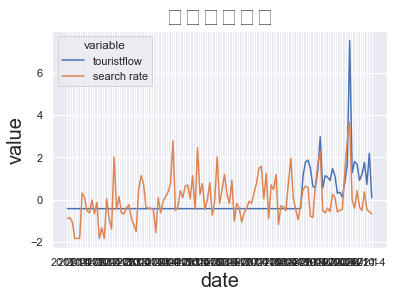

In [143]:
import matplotlib.pyplot as plt
import seaborn as sns
from seaborn.palettes import color_palette
sns.set_style("whitegrid",{"font.sans-serif":['Microsoft JhengHei']}) # 使用內建的微軟正黑體
sns.set_theme(style="darkgrid")

output_folder_fig = os.path.join(output_folder, 'deferred_plot')
if not os.path.exists(output_folder_fig):
    os.mkdir(output_folder_fig)


# 讀取資料
df = pd.read_csv(os.path.join(output_folder, 'googletrend_touristflow_deferred_nor.v1.csv'))
df['date'] = df['year'].astype(str) + '-' + df['month'].astype(str)

for spot in df['name'].unique():
    plt.clf()
    tmp = df[df['name']==spot]

    plot_data = tmp.melt(id_vars=['date'], value_vars=['touristflow_nor'])
    plot_data = pd.concat([plot_data, tmp.melt(id_vars=['date'], value_vars=['search_rate_nor'])])
    plot_data['variable'] = plot_data['variable'].apply(lambda x: 'touristflow' if x=='touristflow_nor' else 'search rate')

    plot = sns.lineplot(x="date", y="value", hue='variable', data=plot_data)

    for ind, label in enumerate(plot.get_xticklabels()):
        if ind % 3 == 0:
            label.set_visible(True)
        else:
            label.set_visible(False)

    plt.title('{}'.format(spot), fontsize=24)
    plt.xlabel('date', fontsize=20)
    plt.ylabel('value', fontsize=20)

    # plt.show()
    plt.savefig(os.path.join(output_folder_fig, '{}.png'). format(spot))

<Figure size 432x288 with 0 Axes>

<Figure size 504x504 with 0 Axes>

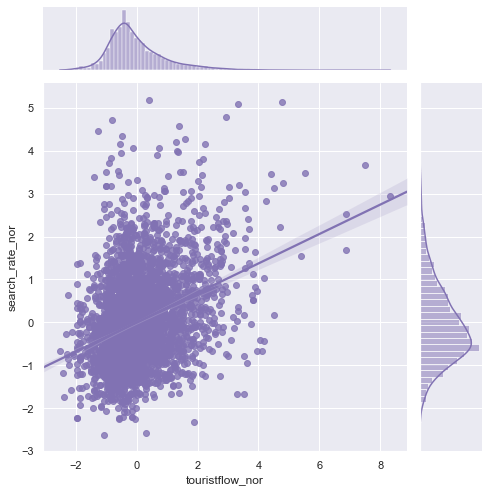

In [144]:

# =============================
# 看兩個變數的趨勢圖

path = os.path.join(output_folder, 'Correlation')
if not os.path.exists(path):
    os.makedirs(path)


# 相形圖，看兩變數的區間分佈
plt.clf()
df['touristflow'].plot.hist(bins=10, alpha=0.7)
plt.savefig(os.path.join(path, 'peopleflow_hist.png'))

plt.clf()
df['touristflow_nor'].plot.hist(bins=10, alpha=0.7)
plt.savefig(os.path.join(path, 'peopleflow_nor_hist.png'))

plt.clf()
df['search_rate'].plot.hist(bins=10, alpha=0.7, color='seagreen')
plt.savefig(os.path.join(path, 'search_rate_hist.png'))

plt.clf()
df['search_rate_nor'].plot.hist(bins=10, alpha=0.7, color='seagreen')
plt.savefig(os.path.join(path, 'search_rate_nor_hist.png'))


# 散佈圖與區間分佈相形圖圖
plt.clf()
g = sns.jointplot(x="touristflow", y="search_rate", data=df,
                    kind="reg", truncate=False,
                    # xlim=(0, 60), ylim=(0, 12),
                    color="m", height=7)
plt.savefig(os.path.join(path, 'jointplot.png'))

plt.clf()
g = sns.jointplot(x="touristflow_nor", y="search_rate_nor", data=df,
                    kind="reg", truncate=False,
                    # xlim=(0, 60), ylim=(0, 12),
                    color="m", height=7)
plt.savefig(os.path.join(path, 'jointplot_nor.png'))